# Data Explore



In [34]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

DATA_PATH = '/mnt/ai_challenger_caption_train_20170902'

In [71]:
import json

f = open(DATA_PATH + '/caption_train_annotations_20170902.json', 'r')
caption_labels = json.loads(f.read())
print "total image num is %d" % len(caption_labels)

total image num is 210000


0d9ca297dac4bcb577b09ef9d479cbc6a043db89.jpg
	 1,球场上有一个左手抬起的女人在打网球
	 2,运动场上一个右手拿着网球拍的女人在打网球
	 3,一个穿着裙子的女人在运动场上打网球
	 4,球场上有一个右手拿着球拍的运动员在打网球
	 5,球场上有一个右手拿着球拍的运动员在打网球


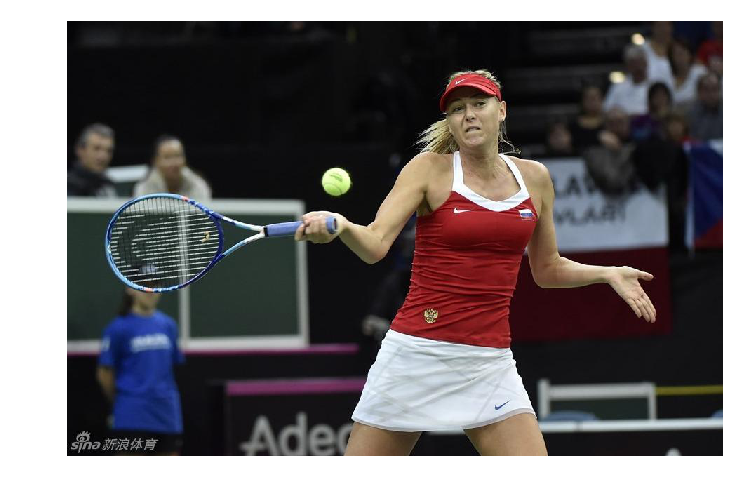

In [106]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sample_idx = 100

sample_doc = caption_labels[sample_idx]
image_path = DATA_PATH + '/caption_train_images_20170902/' + sample_doc['image_id']
print sample_doc['image_id']
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
for idx, sent in enumerate(sample_doc[u'caption'], 1):
    print '\t %d,%s' % (idx, sent)

# resize the image to 224 * 224, which suited for VGGnet

In [35]:
from PIL import Image
import os


def resize_image(image):
    width, height = image.size
    if width > height:
        left = (width - height) / 2
        right = width - left
        top = 0
        bottom = height
    else:
        top = (height - width) / 2
        bottom = height - top
        left = 0
        right = width
    image = image.crop((left, top, right, bottom))
    image = image.resize([224, 224], Image.ANTIALIAS)
    return image

In [33]:
img_resized = resize_image(img)
plt.imshow(img_resized)
plt.axis('off')

NameError: name 'img' is not defined

# preprocess data

In [111]:
import jieba
import pandas as pd
from core.utils import *
from collections import Counter
import os
def fenci(sentence):
    return ' '.join(jieba.cut(sentence))


def _process_caption_data(caption_file, image_dir, max_length):
    with open(caption_file) as f:
        raw_data = json.load(f)
    print "there are %d samples in %s" % (len(raw_data), caption_file)
    
    caption_data = []
    miss_count = 0
    for sample in raw_data:
        image_file_name = os.path.join(image_dir, sample['image_id'])
        if not os.path.exists(image_file_name):
            miss_count += 1
            if miss_count % 100 == 0:
                print "miss count %d " % miss_count
            continue
        for caption in sample['caption']:
            sample_dict = {'caption': caption,
                           'fenci_caption': fenci(caption),
                           'image_file_name': image_file_name,
                          'image_id': sample['image_id']}
            caption_data.append(sample_dict)
    
    # convert to pandas dataframe (for later visualization or debugging)
    caption_data = pd.DataFrame.from_dict(caption_data)
    caption_data.sort_values(by='image_id', inplace=True)
    caption_data = caption_data.reset_index(drop=True)
    
    return caption_data


def _build_vocab(annotations, threshold=1):
    counter = Counter()
    max_len = 0
    for i, caption in enumerate(annotations['fenci_caption']):
        words = caption.split(' ') # caption contrains only lower-case words
        for w in words:
            counter[w] +=1

        if len(caption.split(" ")) > max_len:
            max_len = len(caption.split(" "))

    vocab = [word for word in counter if counter[word] >= threshold]
    print ('Filtered %d words to %d words with word count threshold %d.' % (len(counter), len(vocab), threshold))

    word_to_idx = {u'<NULL>': 0, u'<START>': 1, u'<END>': 2}
    idx = 3
    for word in vocab:
        word_to_idx[word] = idx
        idx += 1
    print "Max length of caption: ", max_len
    return word_to_idx

def _build_caption_vector(annotations, word_to_idx, max_length=15):
    n_examples = len(annotations)
    captions = np.ndarray((n_examples,max_length+2)).astype(np.int32)   

    for i, caption in enumerate(annotations['fenci_caption']):
        words = caption.split(" ") # caption contrains only lower-case words
        cap_vec = []
        cap_vec.append(word_to_idx['<START>'])
        for word in words:
            if word in word_to_idx:
                cap_vec.append(word_to_idx[word])
            if len(cap_vec) > max_length:
                break
        cap_vec.append(word_to_idx['<END>'])
        
        # pad short caption with the special null token '<NULL>' to make it fixed-size vector
        if len(cap_vec) < (max_length + 2):
            for j in range(max_length + 2 - len(cap_vec)):
                cap_vec.append(word_to_idx['<NULL>']) 
        
        captions[i, :] = np.asarray(cap_vec)
    print "Finished building caption vectors"
    return captions

def _build_file_names(annotations):
    image_file_names = []
    id_to_idx = {}
    idx = 0
    image_ids = annotations['image_id']
    file_names = annotations['image_file_name']
    for image_id, file_name in zip(image_ids, file_names):
        if not image_id in id_to_idx:
            id_to_idx[image_id] = idx
            image_file_names.append(file_name)
            idx += 1

    file_names = np.asarray(image_file_names)
    return file_names, id_to_idx

def _build_image_idxs(annotations, id_to_idx):
    image_idxs = np.ndarray(len(annotations), dtype=np.int32)
    image_ids = annotations['image_id']
    for i, image_id in enumerate(image_ids):
        image_idxs[i] = id_to_idx[image_id]
    return image_idxs



In [112]:
# batch size for extracting feature vectors from vggnet.
batch_size = 100
# maximum length of caption(number of word). if caption is longer than max_length, deleted.  
max_length = 15
# if word occurs less than word_count_threshold in training dataset, the word index is special unknown token.
word_count_threshold = 1

train_caption_file = DATA_PATH + '/caption_train_annotations_20170902.json'
image_dir = DATA_PATH + '/caption_train_images_20170902/'
train_dataset = _process_caption_data(caption_file, image_dir, max_length)

# about 4000 images and 20000 captions for val / test dataset
val_cutoff = int(0.05 * len(train_dataset))
test_cutoff = int(0.1 * len(train_dataset))

save_pickle(train_dataset[:val_cutoff], 'data/val/val.annotations.pkl')
save_pickle(train_dataset[val_cutoff:test_cutoff].reset_index(drop=True), 'data/test/test.annotations.pkl')
save_pickle(train_dataset[test_cutoff:].reset_index(drop=True), 'data/train/train.annotations.pkl')

for split in ['train', 'val', 'test']:
    annotations = load_pickle('./data/%s/%s.annotations.pkl' % (split, split))

    if split == 'train':
        word_to_idx = _build_vocab(annotations=annotations, threshold=word_count_threshold)
        save_pickle(word_to_idx, './data/%s/word_to_idx.pkl' % split)

    captions = _build_caption_vector(annotations=annotations, word_to_idx=word_to_idx, max_length=max_length)
    save_pickle(captions, './data/%s/%s.captions.pkl' % (split, split))

    file_names, id_to_idx = _build_file_names(annotations)
    save_pickle(file_names, './data/%s/%s.file.names.pkl' % (split, split))

    image_idxs = _build_image_idxs(annotations, id_to_idx)
    save_pickle(image_idxs, './data/%s/%s.image.idxs.pkl' % (split, split))

    # prepare reference captions to compute bleu scores later
    image_ids = set()
    feature_to_captions = {}
    i = -1
    for caption, image_id in zip(annotations['caption'], annotations['image_id']):
        if not image_id in image_ids:
            image_ids.add(image_id)
            i += 1
            feature_to_captions[i] = []
        feature_to_captions[i].append(caption + ' .')
    save_pickle(feature_to_captions, './data/%s/%s.references.pkl' % (split, split))
    print "Finished building %s caption dataset" %split



there are 210000 samples in /mnt/ai_challenger_caption_train_20170902/caption_train_annotations_20170902.json
miss count 100 
miss count 200 
miss count 300 
miss count 400 
miss count 500 
miss count 600 
miss count 700 
Saved data/val/val.annotations.pkl..
Saved data/test/test.annotations.pkl..
Saved data/train/train.annotations.pkl..
Loaded ./data/train/train.annotations.pkl..
Filtered 16935 words to 16935 words with word count threshold 1.
Max length of caption:  37
Saved ./data/train/word_to_idx.pkl..
Finished building caption vectors
Saved ./data/train/train.captions.pkl..
Saved ./data/train/train.file.names.pkl..
Saved ./data/train/train.image.idxs.pkl..
Saved ./data/train/train.references.pkl..
Finished building train caption dataset
Loaded ./data/val/val.annotations.pkl..
Finished building caption vectors
Saved ./data/val/val.captions.pkl..
Saved ./data/val/val.file.names.pkl..
Saved ./data/val/val.image.idxs.pkl..
Saved ./data/val/val.references.pkl..
Finished building val ca

# init Model

In [17]:
import core.solver
reload(core.solver)
import core.model
reload(core.model)
import core.vggnet
reload(core.vggnet)
import sys
sys.path.append('/home/carnd/coco-caption')  
from core.solver import CaptioningSolver
from core.model import CaptionGenerator
from core.utils import load_coco_data
import tensorflow as tf
init_op = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init_op)
tf.reset_default_graph()

# load train dataset
data = load_coco_data(data_path='./data', split='train')
word_to_idx = data['word_to_idx']
# load val dataset to print out bleu scores every epoch
val_data = load_coco_data(data_path='./data', split='val')

model = CaptionGenerator(word_to_idx, dim_feature=[196, 512], dim_embed=512,
                                   dim_hidden=1024, n_time_step=16, prev2out=True, 
                                             ctx2out=True, alpha_c=1.0, selector=True, dropout=True)


Loaded ./data/train/train.annotations.pkl..
image_idxs <type 'numpy.ndarray'> (941850,) int32
file_names <type 'numpy.ndarray'> (188370,) <U116
word_to_idx <type 'dict'> 16938
image_path <type 'numpy.ndarray'> (188370,) <U116
captions <type 'numpy.ndarray'> (941850, 17) int32
Elapse time: 2.33
Loaded ./data/val/val.annotations.pkl..
image_idxs <type 'numpy.ndarray'> (52325,) int32
file_names <type 'numpy.ndarray'> (10465,) <U116
image_path <type 'numpy.ndarray'> (10465,) <U116
captions <type 'numpy.ndarray'> (52325, 17) int32
Elapse time: 0.13


In [18]:
vgg_model_path = '/mnt/image_caption/show-attend-and-tell/data/imagenet-vgg-verydeep-19.mat'
from core.vggnet import Vgg19
vggnet = Vgg19(vgg_model_path)
vggnet.build()
solver = CaptioningSolver(model, data, val_data, vggnet, n_epochs=20, batch_size=128, update_rule='adam',
                                      learning_rate=0.001, print_every=1000, save_every=1, image_path='./image/',
                                pretrained_model=None, model_path='model/lstm/', test_model='model/lstm/model-10',
                                 print_bleu=True, log_path='log/')

In [19]:
solver.train()

The number of epoch: 20
Data size: 941850
Batch size: 128
Iterations per epoch: 7359


ValueError: setting an array element with a sequence.

In [47]:
from scipy import ndimage

def extract_image_feature(sess, vggnet, image_batch_file):
    image_batch = np.array(map(lambda x: ndimage.imread(resize_image(Image.open(x)), mode='RGB'), image_batch_file)).astype(
        np.float32)
    feats = sess.run(vggnet.features, feed_dict={vggnet.images: image_batch})
    return feats

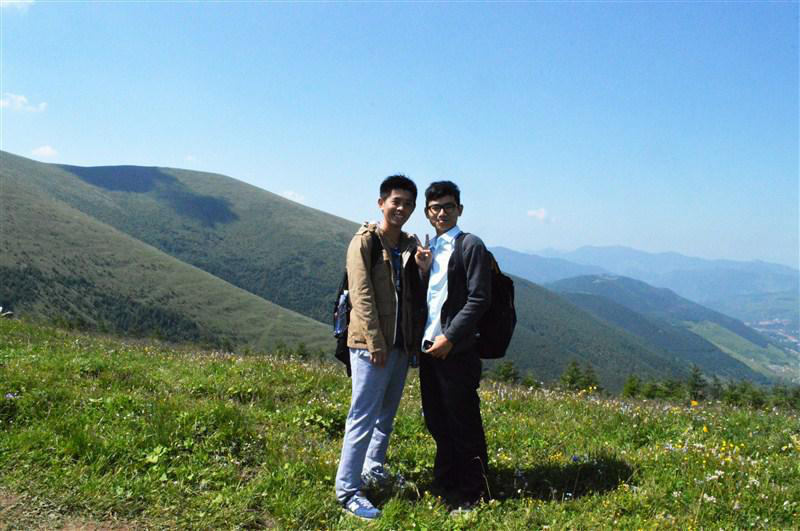

In [44]:
sess, vggnet, data.keys()
img = Image.open(data['file_names'][0])
img

In [48]:
tt = extract_image_feature(sess, vggnet, data['file_names'][:3])

AttributeError: 'Image' object has no attribute 'read'

In [30]:
image_batch_file = data['file_names'][:3]

[array([[[221, 232, 238],
        [236, 247, 253],
        [225, 236, 242],
        ..., 
        [103, 166, 235],
        [108, 171, 240],
        [116, 179, 248]],

       [[230, 243, 251],
        [245, 255, 255],
        [234, 247, 255],
        ..., 
        [110, 173, 242],
        [114, 177, 246],
        [122, 185, 254]],

       [[217, 231, 240],
        [232, 246, 255],
        [217, 234, 242],
        ..., 
        [105, 168, 237],
        [109, 172, 241],
        [116, 179, 248]],

       ..., 
       [[107,  98,  67],
        [108, 102,  68],
        [148, 143, 105],
        ..., 
        [121, 126,  62],
        [ 56,  65,   2],
        [ 54,  64,   1]],

       [[113, 104,  73],
        [119, 113,  79],
        [156, 151, 113],
        ..., 
        [126, 131,  67],
        [ 71,  80,  17],
        [ 81,  91,  28]],

       [[119, 110,  79],
        [130, 124,  90],
        [165, 160, 122],
        ..., 
        [127, 132,  68],
        [ 82,  91,  28],
        [104, 114